# Road sign detection on IoT devices

This project centers on crafting an intelligent traffic sign recognition model that can run on Arduino devices. Starting from the GTSRB roadsign dataset, we create seven distinct datasets for training, validation, and testing. A Convolutional Neural Network was trained (in Kaggle) and then used to process data, creating 64-feature representations compatible with the limited memory on the Arduino. Small Multi-layer Perceptrons were trained on the device and evaluated both against a high-quality dataset and images captured with the Arduino’s own camera.

Results showcased successful single-device training and improved performance in distributed training. Challenges arose from low-quality Arduino-captured images. In summary, the project successfully demonstrated machine learning integration on Arduino for practical traffic sign recognition and the benefit of distributed learning.

## This notebook
This notebook processes data, builds a CNN, converts data throught the CNN and exports said data.

The project also includes C++ code for on-device machine learning.

## The arduino
ARDUNIO Nano 33 BLE Sense (**256 KB SRAM, 1MB flash**)
Camera resolution: 640x480 pixels = 0.3mb

# Install neccessary stuff

In [2]:
import tensorflow as tf # for deep learning
import keras # for deep learning
import sklearn # for machine learning
import matplotlib as plt # for plotting
import pandas as pd # for data manipulation
import numpy as np # for data manipulation
import cv2

from PIL import Image # Python Imaging Library
import os # provides functions for creating and removing a directory (folder), fetching its contents, changing and identifying the current directory, etc
from sklearn.model_selection import train_test_split #  splits arrays or matrices into random subsets for train and test data
from keras.utils import to_categorical # Converts a class vector (integers) to binary class matrix. E.g. for use with categorical_crossentropy
from keras.models import Sequential # allows us to specify a neural network, precisely, sequential: from input to output, passing through a series of neural layers, one after the other
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout # layers for our NN
from keras.models import load_model # for saving the model inbetween sessions
from sklearn.model_selection import StratifiedShuffleSplit # For splits of data that preserve distribution of samples
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels
import seaborn as sns


# Data load and processing
1. We select only 10 of the 43 classes, reducing the dataset from ~50K to ~14K samples.
2. We load the images and convert them to numpy arrays usuing a bilinear image converter.
3. The data is shuffeled since it is loaded in a structured manner.
4. We split the entire set into two sets: A and B. Throughout all splits, the distriubution of the 10 classes is preserved,

    4.1. The set A will be used for training the convolutional neural network, with unrestricted hardware.
    
    4.2. The set B will be futher split into parts and used on-device.
    
    4.3. A constitutes 97% and B 3% of the dataset.
5. A is split into training and validation data. We are not interested in the generalization performance of the CNN.
6. B is split into three parts; training, validation and testing (generalization).
7. B-training is split into two parts; B1 and B2. Here, a splitting strategy is used so that only 7 classes are present in each set, creating an overlap of 4 classes between the two sets. These sets will be used for federated learning. The validation and testing part of the set B are not futher split, i.e. all distributed arduinos are validated and tested against the same data.


In [3]:
#DATA LOADING
# Paths to data
data_dir = '../input/gtsrb-german-traffic-sign' #Folders by label
arduino_dir = '../input/arduino-samples/' #Folders by label
train_path = '../input/gtsrb-german-traffic-sign/Train'#Direct path to images
test_path = '../input/gtsrb-german-traffic-sign/' #Folders by label

# Parameters for resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3 #RGB

# All classes (not used anymore)
num_categories = len(os.listdir(train_path))

# SELECTING 10 classes (later they are numbered 0-9 in the same order)
classes = { 2:'Speed limit (50km/h)', 
            9:'No passing',
            14:'Stop',
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory'}

classes_0_to_9 = { 0:'Speed limit (50km/h)', 
            1:'No passing',
            2:'Stop',
            3:'Veh > 3.5 tons prohibited', 
            4:'No entry', 
            5:'Turn right ahead', 
            6:'Turn left ahead', 
            7:'Keep right', 
            8:'Keep left', 
            9:'Roundabout mandatory'}

selected_categories = classes.keys()
selected_categories_0_to_9 = classes_0_to_9.keys()
num_categories = len(selected_categories)
print("Number of selected categories: ", num_categories)
print("They are: ", selected_categories)
print("They will later be named as", selected_categories_0_to_9)

Number of selected categories:  10
They are:  dict_keys([2, 9, 14, 16, 17, 33, 34, 38, 39, 40])
They will later be named as dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


### Loading the dataset

In [4]:
#DATA PROCESSING
image_data = []
image_labels = []

# Loads and processes an image, returns it as numpy array
def load_and_preprocess_image(file_path):
    img1 = Image.open(file_path)
    img1_resized = img1.resize((IMG_HEIGHT, IMG_WIDTH), resample=Image.BILINEAR).convert("RGB") #quality-preserving image conversion
    img1_array = np.array(img1_resized)
    return img1_array

# Fetch images and label them correctly 0-9
for i,n in enumerate(selected_categories):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)
    print("Currently processing samples of class", n,"labeling them as class", i)
    
    for img in images:
        try:
            image_data.append(load_and_preprocess_image(path + '/' + img))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Convert to NumpyArray that contains NumpyArrays
image_data = np.array(image_data)
image_labels = np.array(image_labels)
 
#normalization of pixel values from [0,255] to [0,1]
image_data = image_data/255

# One-hot encoding of labels
image_labels = to_categorical(image_labels, num_categories)

print("Shape of samples:", image_data.shape)
print("Shape of labels:", image_labels.shape)


Currently processing samples of class 2 labeling them as class 0
Currently processing samples of class 9 labeling them as class 1
Currently processing samples of class 14 labeling them as class 2
Currently processing samples of class 16 labeling them as class 3
Currently processing samples of class 17 labeling them as class 4
Currently processing samples of class 33 labeling them as class 5
Currently processing samples of class 34 labeling them as class 6
Currently processing samples of class 38 labeling them as class 7
Currently processing samples of class 39 labeling them as class 8
Currently processing samples of class 40 labeling them as class 9
Shape of samples: (14670, 30, 30, 3)
Shape of labels: (14670, 10)


### Loading data captured via the arduino on-device camera

In [5]:
#DATA PROCESSING
arduino_data = []
arduino_labels = []

# Fetch ARDUINO images and label them 0 to 9
for i in selected_categories_0_to_9:
    path = arduino_dir + str(i)
    images = os.listdir(path)
    print("Currently processing samples of class", i,"labeling them as class", i)
    
    for img in images:
        try:
            arduino_data.append(load_and_preprocess_image(path + '/' + img))
            arduino_labels.append(i)
        except:
            print("Error in " + img)

# Convert to NumpyArray that contains NumpyArrays
arduino_data = np.array(arduino_data)
arduino_labels = np.array(arduino_labels)
 
#normalization of pixel values from [0,255] to [0,1]
arduino_data = arduino_data/255

# One-hot encoding of labels
arduino_labels = to_categorical(arduino_labels, num_categories)

print("Shape of samples:", arduino_data.shape)
print("Shape of labels:", arduino_labels.shape)


Currently processing samples of class 0 labeling them as class 0
Currently processing samples of class 1 labeling them as class 1
Currently processing samples of class 2 labeling them as class 2
Currently processing samples of class 3 labeling them as class 3
Currently processing samples of class 4 labeling them as class 4
Currently processing samples of class 5 labeling them as class 5
Currently processing samples of class 6 labeling them as class 6
Currently processing samples of class 7 labeling them as class 7
Currently processing samples of class 8 labeling them as class 8
Currently processing samples of class 9 labeling them as class 9
Shape of samples: (36, 30, 30, 3)
Shape of labels: (36, 10)


## Shuffling the data

In [6]:
#DATA SHUFFLING
def shuffle(image_data, image_labels):
    # Create an shuffled array of indices
    shuffle_indexes = np.arange(image_data.shape[0])
    np.random.seed(42)
    np.random.shuffle(shuffle_indexes)

    # Reorder the rows of image_data based on the shuffled indices
    image_data = image_data[shuffle_indexes]

    # Reorder the corresponding labels based on the same shuffled indices
    image_labels = image_labels[shuffle_indexes]
        
    return(image_data, image_labels)

image_data, image_labels = shuffle(image_data, image_labels)
arduino_data, arduino_labels = shuffle(arduino_data, arduino_labels)
print("Data and labels have now been shuffeled")

Data and labels have now been shuffeled


## Splitting the training data into two sets A and B.
A will be used for training the CNN, while B is set aside for on-device training of the MLP.
A is assigned 97% of the data, while 3% is reserved for set B.

In [7]:
# Split data into A and B, in a way that preserves the distribution of classes
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.03, random_state=42)

for train_index, test_index in sss.split(image_data, image_labels):
    image_data_a, image_data_b = image_data[train_index], image_data[test_index]
    image_labels_a, image_labels_b = image_labels[train_index], image_labels[test_index]

# Display information about Model A's training data
print("Set A:")
print("Number of samples in image_data_a:", image_data_a.shape[0])
print("Shape of image_data_a:", image_data_a.shape)
print("Number of samples in image_labels_a:", image_labels_a.shape[0])
print("Shape of image_labels_a:", image_labels_a.shape)

# Display information about Model B's training data
print("\nSet B:")
print("Number of samples in image_data_b:", image_data_b.shape[0])
print("Shape of image_data_b:", image_data_b.shape)
print("Number of samples in image_labels_b:", image_labels_b.shape[0])
print("Shape of image_labels_b:", image_labels_b.shape)

Set A:
Number of samples in image_data_a: 14229
Shape of image_data_a: (14229, 30, 30, 3)
Number of samples in image_labels_a: 14229
Shape of image_labels_a: (14229, 10)

Set B:
Number of samples in image_data_b: 441
Shape of image_data_b: (441, 30, 30, 3)
Number of samples in image_labels_b: 441
Shape of image_labels_b: (441, 10)


## Validate that distribution has been preserved in both A and B

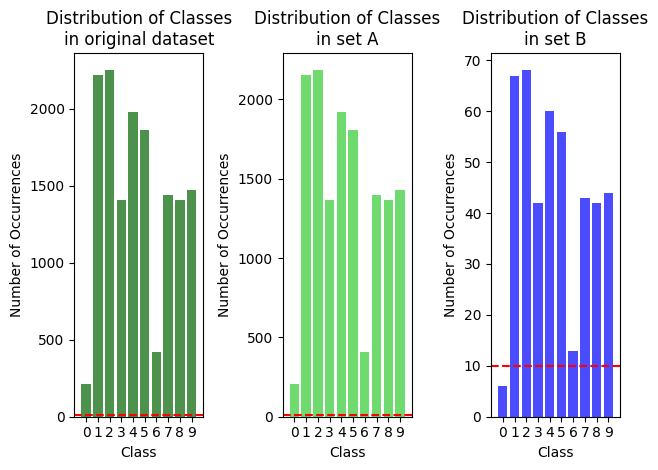

As seen above, distrubution has been preserved in both datasets


In [8]:
# Get unique classes and their counts for image_data_a,after convert back from one-hot
integer_labels_original = np.argmax(image_labels, axis=1)
integer_labels_a = np.argmax(image_labels_a, axis=1)
integer_labels_b = np.argmax(image_labels_b, axis=1)
classes_original, counts_original = np.unique(integer_labels_original, return_counts=True)
classes_a, counts_a = np.unique(integer_labels_a, return_counts=True)
classes_b, counts_b = np.unique(integer_labels_b, return_counts=True)

# Plot histogram for the original dataset
plt.subplot(1, 3, 1)
plt.bar(classes_original, counts_original, color='darkgreen', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.title('Distribution of Classes\nin original dataset')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

# Plot histogram for image_data_a
plt.subplot(1, 3, 2)
plt.bar(classes_a, counts_a, color='limegreen', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.title('Distribution of Classes\nin set A')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

# Plot histogram for image_data_b
plt.subplot(1, 3, 3)
plt.bar(classes_b, counts_b, color='blue', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.title('Distribution of Classes\nin set B')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
print("As seen above, distrubution has been preserved in both datasets")


## Split the data in set A into train and validation set

In [9]:
# DATASET A
sss_a = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in sss_a.split(image_data_a, image_labels_a):
    x_train_a, x_val_a = image_data_a[train_index], image_data_a[val_index]
    y_train_a, y_val_a = image_labels_a[train_index], image_labels_a[val_index]

# Display information about Model A's training data
print("CNN - Training Data:")
print("Number of samples in x_train_a:", x_train_a.shape[0])
print("Shape of x_train_a:", x_train_a.shape)
print("Number of samples in y_train_a:", y_train_a.shape[0])
print("Shape of y_train_a:", y_train_a.shape)

# Display information about Model A's validation data
print("\nCNN - Validation Data:")
print("Number of samples in x_val_a:", x_val_a.shape[0])
print("Shape of x_val_a:", x_val_a.shape)
print("Number of samples in y_val_a:", y_val_a.shape[0])
print("Shape of y_val_a:", y_val_a.shape)

CNN - Training Data:
Number of samples in x_train_a: 11383
Shape of x_train_a: (11383, 30, 30, 3)
Number of samples in y_train_a: 11383
Shape of y_train_a: (11383, 10)

CNN - Validation Data:
Number of samples in x_val_a: 2846
Shape of x_val_a: (2846, 30, 30, 3)
Number of samples in y_val_a: 2846
Shape of y_val_a: (2846, 10)


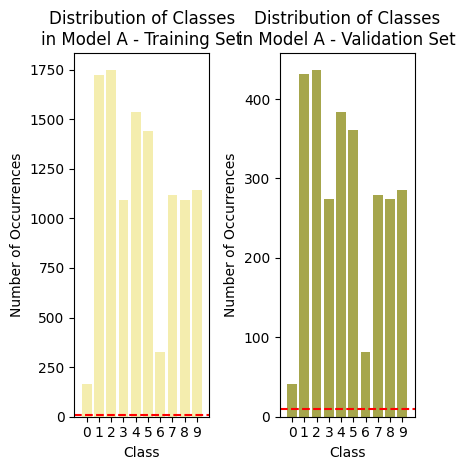

In [10]:
integer_labels_train_a = np.argmax(y_train_a, axis=1)
classes_train_a, counts_train_a = np.unique(integer_labels_train_a, return_counts=True)
integer_labels_val_a = np.argmax(y_val_a, axis=1)
classes_val_a, counts_val_a = np.unique(integer_labels_val_a, return_counts=True)

# Plot histogram for the training set of Model A
plt.subplot(1, 3, 1)
plt.bar(classes_train_a, counts_train_a, color='khaki', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.title('Distribution of Classes\nin Model A - Training Set')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

# Plot histogram for the validation set of Model A
plt.subplot(1, 3, 2)
plt.bar(classes_val_a, counts_val_a, color='olive', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.title('Distribution of Classes\nin Model A - Validation Set')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

plt.tight_layout()
plt.show()

## Split the data in set B into train (B0), validation & generalization set

In [11]:
# Split B into training and a temporary variable, 70% vs 30%
sss_b = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, val_index in sss_b.split(image_data_b, image_labels_b):
    x_train_b, x_temp_b = image_data_b[train_index], image_data_b[val_index]
    y_train_b, y_temp_b = image_labels_b[train_index], image_labels_b[val_index]

# Split the temporary variable into val and test, 50% and 50%
sss_b = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for train_index, val_index in sss_b.split(x_temp_b, y_temp_b):
    x_val_b, x_test_b = x_temp_b[train_index], x_temp_b[val_index]
    y_val_b, y_test_b = y_temp_b[train_index], y_temp_b[val_index]

# Display information about Model B's training data
print("Dataset B - Training Data:")
print("Number of samples in x_train_b:", x_train_b.shape[0])
print("Shape of x_train_b:", x_train_b.shape)
print("Number of samples in y_train_b:", y_train_b.shape[0])
print("Shape of y_train_b:", y_train_b.shape)

# Display information about Model B's validation data
print("\nDataset B - Validation Data:")
print("Number of samples in x_val_b:", x_val_b.shape[0])
print("Shape of x_val_b:", x_val_b.shape)
print("Number of samples in y_val_b:", y_val_b.shape[0])
print("Shape of y_val_b:", y_val_b.shape)

# Display information about Model B's test data
print("\nDataset B - Test Data:")
print("Number of samples in x_test_b:", x_test_b.shape[0])
print("Shape of x_test_b:", x_test_b.shape)
print("Number of samples in y_test_b:", y_test_b.shape[0])
print("Shape of y_test_b:", y_test_b.shape)

Dataset B - Training Data:
Number of samples in x_train_b: 308
Shape of x_train_b: (308, 30, 30, 3)
Number of samples in y_train_b: 308
Shape of y_train_b: (308, 10)

Dataset B - Validation Data:
Number of samples in x_val_b: 66
Shape of x_val_b: (66, 30, 30, 3)
Number of samples in y_val_b: 66
Shape of y_val_b: (66, 10)

Dataset B - Test Data:
Number of samples in x_test_b: 67
Shape of x_test_b: (67, 30, 30, 3)
Number of samples in y_test_b: 67
Shape of y_test_b: (67, 10)


## Split Training data in B0 into two sets, B1 and B2
We now split the tranining data into two partially disjoints sets, in preperation for training on two different arduino devices.

The two sets will be **partially disjoint** with respect to classes: 3 classes are unique to B1, 3 classes are unique to B2, 4 classes are present in both sets.

The two sets will be **completely disjoint** with respect to samples: each sample may only exist in either B1 or B2. This resembles the fact that the two arduinos have completely different experiences that they've learnt from.

B1 contains unqiely
* 1:'Speed limit (50km/h)'
* 2:'No passing'
* 5:'No entry'

B2 contains unqiely
* 6:'Turn right ahead'
* 8:'Keep right'
* 9:'Keep left'

Both B1 and B2 contains samples from
* 3:'Stop',
* 4:'Veh > 3.5 tons prohibited', 
* 7:'Turn left ahead', 
* 10:'Roundabout mandatory'



In [12]:
# The classes that should be unique to either B1 or B2, 
B1_classes_to_extract = (0,1,4) # shifted left to 0-based indexes
B2_classes_to_extract = (5,7,8) # shifted left to 0-based indexes

# Find indices
B1_class_indices = np.where(np.isin(np.argmax(y_train_b, axis=1), B1_classes_to_extract))[0]
B2_class_indices = np.where(np.isin(np.argmax(y_train_b, axis=1), B2_classes_to_extract))[0]

# Extract samples
B1_images = x_train_b[B1_class_indices]
B2_images = x_train_b[B2_class_indices]

# Extract labels
B1_labels = y_train_b[B1_class_indices]
B2_labels = y_train_b[B2_class_indices]

# Remove samples and labels from a copy of the original datasets. The originals are left unchanged.
x_train_b_copy = np.delete(x_train_b, np.concatenate((B1_class_indices, B2_class_indices)), axis=0)
y_train_b_copy = np.delete(y_train_b, np.concatenate((B1_class_indices, B2_class_indices)), axis=0)

# Split the shared classes evenly, preserving class distribution
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for part1_index, part2_index in sss.split(x_train_b_copy, y_train_b_copy):
    x_B1, x_B2 = x_train_b_copy[part1_index], x_train_b_copy[part2_index]
    y_B1, y_B2 = y_train_b_copy[part1_index], y_train_b_copy[part2_index]
    
# Merge the unique classes with samples from the common classes (stack vertically)
B1_images = np.vstack((B1_images, x_B1))
B1_labels = np.vstack((B1_labels, y_B1))
B2_images = np.vstack((B2_images, x_B2))
B2_labels = np.vstack((B2_labels, y_B2))

## Validate that B1 and B2 has the desired content
This includes that classes are partially disjoint, samples are completely disjoint and the istribution of shared classes is kept.

... as well as vizualize the arduino samples, the validation data and the training data from set B.

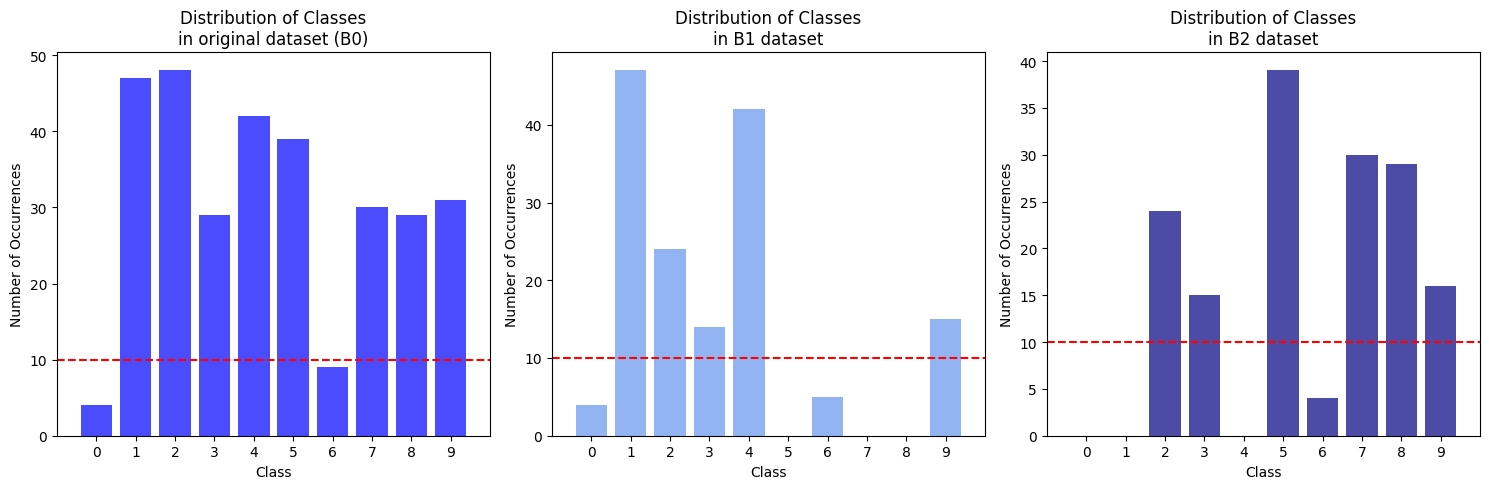

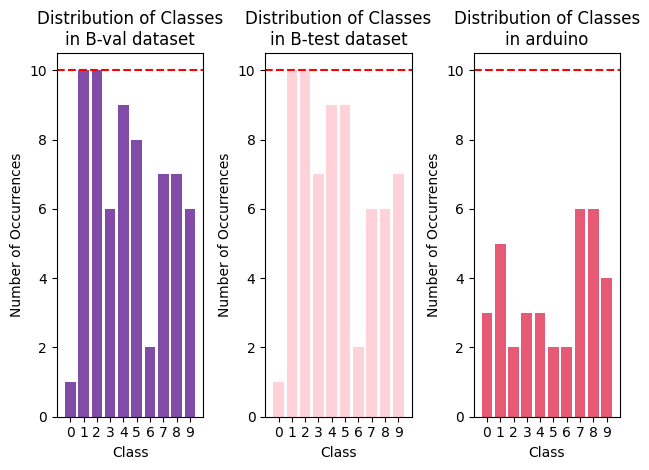


Information B - Training Data:
Number of samples in x_train_b: 308
Shape of x_train_b: (308, 30, 30, 3)
Number of samples in y_train_b: 308
Shape of y_train_b: (308, 10)

Information B1:
Number of samples in B1_images: 151
Shape of B1_images: (151, 30, 30, 3)
Number of samples in B1_labels: 151
Shape of B1_labels: (151, 10)

Information B2:
Number of samples in B2_images: 157
Shape of B2_images: (157, 30, 30, 3)
Number of samples in B2_labels: 157
Shape of B2_labels: (157, 10)


In [28]:
# Get unique classes and their counts, after convert back from one-hot
integer_labels_B = np.argmax(y_train_b, axis=1)
integer_labels_B1 = np.argmax(B1_labels, axis=1)
integer_labels_B2 = np.argmax(B2_labels, axis=1)
integer_labels_val_b = np.argmax(y_val_b, axis=1)
integer_labels_test_b = np.argmax(y_test_b, axis=1)
integer_labels_arduino = np.argmax(arduino_labels, axis=1)

# Get frequency of each class
classes_B, counts_B = np.unique(integer_labels_B, return_counts=True)
classes_B1, counts_B1 = np.unique(integer_labels_B1, return_counts=True)
classes_B2, counts_B2 = np.unique(integer_labels_B2, return_counts=True)
classes_val, counts_val = np.unique(integer_labels_val_b, return_counts=True)
classes_test, counts_test = np.unique(integer_labels_test_b, return_counts=True)
classes_arduino, counts_arduino = np.unique(integer_labels_arduino, return_counts=True)

# Plot histogram for dataset B
plt.subplot(1, 3, 1)
plt.bar(classes_B, counts_B, color='blue', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.title('Distribution of Classes\nin original dataset (B0)')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

# Plot histogram for dataset B1
plt.subplot(1, 3, 2)
plt.bar(classes_B1, counts_B1, color='cornflowerblue', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.title('Distribution of Classes\nin B1 dataset')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

# Plot histogram for dataset B2
plt.subplot(1, 3, 3)
plt.bar(classes_B2, counts_B2, color='navy', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.title('Distribution of Classes\nin B2 dataset')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Plot histogram for dataset validation
plt.subplot(1, 3, 1)
plt.bar(classes_val, counts_val, color='indigo', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.title('Distribution of Classes\nin B-val dataset')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

# Plot histogram for dataset validation
plt.subplot(1, 3, 2)
plt.bar(classes_test, counts_test, color='pink', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.title('Distribution of Classes\nin B-test dataset')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

# Plot histogram for dataset validation
plt.subplot(1, 3, 3)
plt.bar(classes_arduino, counts_arduino, color='crimson', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.title('Distribution of Classes\nin arduino')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Display information about the datasets
print("\nInformation B - Training Data:")
print("Number of samples in x_train_b:", x_train_b.shape[0])
print("Shape of x_train_b:", x_train_b.shape)
print("Number of samples in y_train_b:", y_train_b.shape[0])
print("Shape of y_train_b:", y_train_b.shape)

print("\nInformation B1:")
print("Number of samples in B1_images:", B1_images.shape[0])
print("Shape of B1_images:", B1_images.shape)
print("Number of samples in B1_labels:", B1_labels.shape[0])
print("Shape of B1_labels:", B1_labels.shape)

print("\nInformation B2:")
print("Number of samples in B2_images:", B2_images.shape[0])
print("Shape of B2_images:", B2_images.shape)
print("Number of samples in B2_labels:", B2_labels.shape[0])
print("Shape of B2_labels:", B2_labels.shape)

## Model creation: Convolutional Neural Network

In [ ]:
model = tf.keras.models.Sequential([
    keras.layers.Conv2D(filters=8, kernel_size=(3,3),
                        activation='relu',
                        input_shape=(30,30,3)),
    keras.layers.Conv2D(filters=16, kernel_size=(3,3),
                        activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3),
                        activation='relu'),
    keras.layers.Conv2D(filters=16, kernel_size=(3,3),
                        activation='relu'),
    keras.layers.MaxPool2D(pool_size=(4, 4)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(10, activation='softmax')
])
    
model.summary()

In [12]:
input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)
print("Input shape to model is: ", input_shape)

model = tf.keras.models.Sequential([
    keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(4, 4)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(10, activation='softmax')
])
    
model.summary()

Input shape to model is:  (30, 30, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         224       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 16)        1168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 13, 13, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 16)        2320      
                                                                 
 conv2d_3 (Conv2D)

## Training the model

In [13]:
lr = 0.001
epochs = 100
batch_size = 32

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

history = model.fit(x_train_a, y_train_a, validation_data=(x_val_a, y_val_a), batch_size=batch_size, epochs=epochs)

# When happy with a trained model, save it to working directory
model.save('/kaggle/working/my_model.keras')

Epoch 1/100
356/356 [==============================] - 9s 21ms/step - loss: 2.1749 - accuracy: 0.3159 - val_loss: 1.5647 - val_accuracy: 0.5088
Epoch 2/100
356/356 [==============================] - 7s 19ms/step - loss: 1.0388 - accuracy: 0.6582 - val_loss: 0.5123 - val_accuracy: 0.8524
Epoch 3/100
356/356 [==============================] - 8s 22ms/step - loss: 0.5024 - accuracy: 0.8410 - val_loss: 0.3265 - val_accuracy: 0.9027
Epoch 4/100
356/356 [==============================] - 7s 20ms/step - loss: 0.3204 - accuracy: 0.9013 - val_loss: 0.1974 - val_accuracy: 0.9420
Epoch 5/100
356/356 [==============================] - 7s 20ms/step - loss: 0.2364 - accuracy: 0.9289 - val_loss: 0.1388 - val_accuracy: 0.9589
Epoch 6/100
356/356 [==============================] - 7s 20ms/step - loss: 0.1902 - accuracy: 0.9401 - val_loss: 0.1073 - val_accuracy: 0.9691
Epoch 7/100
356/356 [==============================] - 7s 20ms/step - loss: 0.1603 - accuracy: 0.9519 - val_loss: 0.1005 - val_accuracy:

In [14]:
# Load model from working directory, if lost between session
#model = keras.models.load_model('/kaggle/working/my_model.keras')

In [15]:
# Slash the DNN of the Model, to obtain a partil model of the CNN only. It's output is the flatten layer.
partial_model = keras.models.Model(inputs=model.input, outputs=model.layers[-7].output)
partial_model.summary()

# Also save the DNN as a partial model
# partial_model_DNN_part = keras.models.Model(inputs=model.layers[-5].output, outputs=model.output)
# partial_model_DNN_part.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 30, 30, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 8)         224       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 16)        1168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 13, 13, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 16)        2320  

# Process the B-data through the CNN
This transforms each sample into a feature vector of length 128. The feature vector is suitable as input for on-device training.

In [16]:
# Prediction
B1_processed = partial_model.predict(B1_images)
B2_processed = partial_model.predict(B2_images)
x_val_b_processed = partial_model.predict(x_val_b)
x_test_b_processed = partial_model.predict(x_test_b)
arduino_data_processed = partial_model.predict(arduino_data)

print("\nShape of B1_images", B1_images.shape)
print("Shape of B1_processed", B1_processed.shape)
print("Shape of B1_labels", B1_labels.shape)

print("\nShape of B2_images", B2_images.shape)
print("Shape of B2_processed", B2_processed.shape)
print("Shape of B2_labels", B2_labels.shape)

print("\nShape of x_val_b", x_val_b.shape)
print("Shape of x_val_b_processed", x_val_b_processed.shape)
print("Shape of y_val_b", y_val_b.shape)

print("\nShape of x_test_b", x_test_b.shape)
print("Shape of x_test_b_processed", x_test_b_processed.shape)
print("Shape of y_test_b", y_test_b.shape)

print("\nShape of arduino_data", arduino_data.shape)
print("Shape of arduino_data_processed", arduino_data_processed.shape)
print("Shape of arduino_labels", arduino_labels.shape)

print("\nPeak into B1_processed", B1_processed[0, :3])
print("\nPeak into B2_processed", B2_processed[0, :3])
print("\nPeak into x_val_b_processed", x_val_b_processed[0, :3])
print("\nPeak into x_test_b_processed", x_test_b_processed[0, :3])
print("\nPeak into arduino_data_processed", arduino_data_processed[0, :3])

2/2 [==============================] - 0s 4ms/step

Shape of B1_images (151, 30, 30, 3)
Shape of B1_processed (151, 64)
Shape of B1_labels (151, 10)

Shape of B2_images (157, 30, 30, 3)
Shape of B2_processed (157, 64)
Shape of B2_labels (157, 10)

Shape of x_val_b (66, 30, 30, 3)
Shape of x_val_b_processed (66, 64)
Shape of y_val_b (66, 10)

Shape of x_test_b (67, 30, 30, 3)
Shape of x_test_b_processed (67, 64)
Shape of y_test_b (67, 10)

Shape of arduino_data (36, 30, 30, 3)
Shape of arduino_data_processed (36, 64)
Shape of arduino_labels (36, 10)

Peak into B1_processed [-1.2013106  -0.25340453  0.6694199 ]

Peak into B2_processed [-1.1304857  -0.44109824 -0.5894571 ]

Peak into x_val_b_processed [ 0.21646003 -1.0068686  -0.5465981 ]

Peak into x_test_b_processed [-0.9666371  -1.0068686   0.14087766]

Peak into arduino_data_processed [ 1.3102249  -0.09060427 -0.36251596]


# Check that the data is of high enough quality to be predicted on-laptop
The processed data is now used to train a MLP on the laptop

## Define and train a small MLP using the B1 dataset

In [17]:
input_shape = B1_processed.shape[1]
model_on_device_B1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, activation='relu', input_shape=(input_shape,)),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_on_device_B1.summary()

input_shape = B2_processed.shape[1]
model_on_device_B2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, activation='relu', input_shape=(input_shape,)),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_on_device_B2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                1300      
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
Total params: 1510 (5.90 KB)
Trainable params: 1510 (5.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 20)                1300      
                                                                 
 dense_6 (Dense)             (None, 10)                210       
                                                                 


In [18]:
lr = 0.001
epochs = 100
batch_size = 32

# Train a small model on B1
model_on_device_B1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history_on_device_B1 = model_on_device_B1.fit(B1_processed, B1_labels, validation_data=(x_val_b_processed, y_val_b), batch_size=batch_size, epochs=epochs, verbose=1)
model.save('/kaggle/working/my_model_on_device_B1.keras')

# Train a small model on B2
model_on_device_B2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history_on_device_B2 = model_on_device_B2.fit(B2_processed, B2_labels, validation_data=(x_val_b_processed, y_val_b), batch_size=batch_size, epochs=epochs, verbose=1)
model.save('/kaggle/working/my_model_on_device_B2.keras')

Epoch 1/100
5/5 [==============================] - 1s 51ms/step - loss: 2.5153 - accuracy: 0.0530 - val_loss: 2.4115 - val_accuracy: 0.0909
Epoch 2/100
5/5 [==============================] - 0s 14ms/step - loss: 2.1554 - accuracy: 0.1325 - val_loss: 2.2827 - val_accuracy: 0.1212
Epoch 3/100
5/5 [==============================] - 0s 11ms/step - loss: 1.9400 - accuracy: 0.2583 - val_loss: 2.1968 - val_accuracy: 0.1818
Epoch 4/100
5/5 [==============================] - 0s 13ms/step - loss: 1.7816 - accuracy: 0.3709 - val_loss: 2.1319 - val_accuracy: 0.2273
Epoch 5/100
5/5 [==============================] - 0s 9ms/step - loss: 1.6551 - accuracy: 0.4702 - val_loss: 2.0796 - val_accuracy: 0.2727
Epoch 6/100
5/5 [==============================] - 0s 9ms/step - loss: 1.5530 - accuracy: 0.4967 - val_loss: 2.0372 - val_accuracy: 0.3030
Epoch 7/100
5/5 [==============================] - 0s 9ms/step - loss: 1.4662 - accuracy: 0.5298 - val_loss: 2.0013 - val_accuracy: 0.3333
Epoch 8/100
5/5 [======

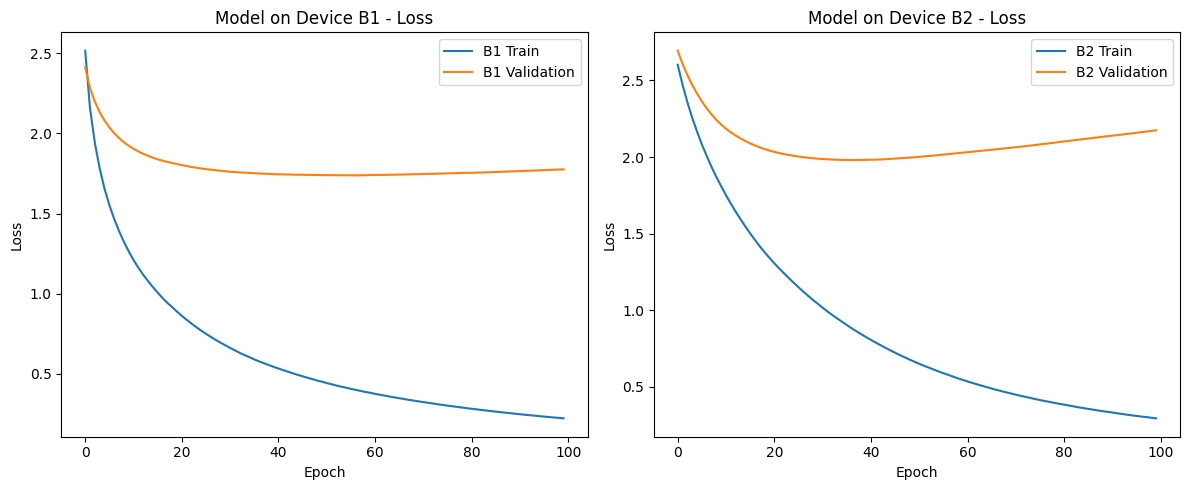

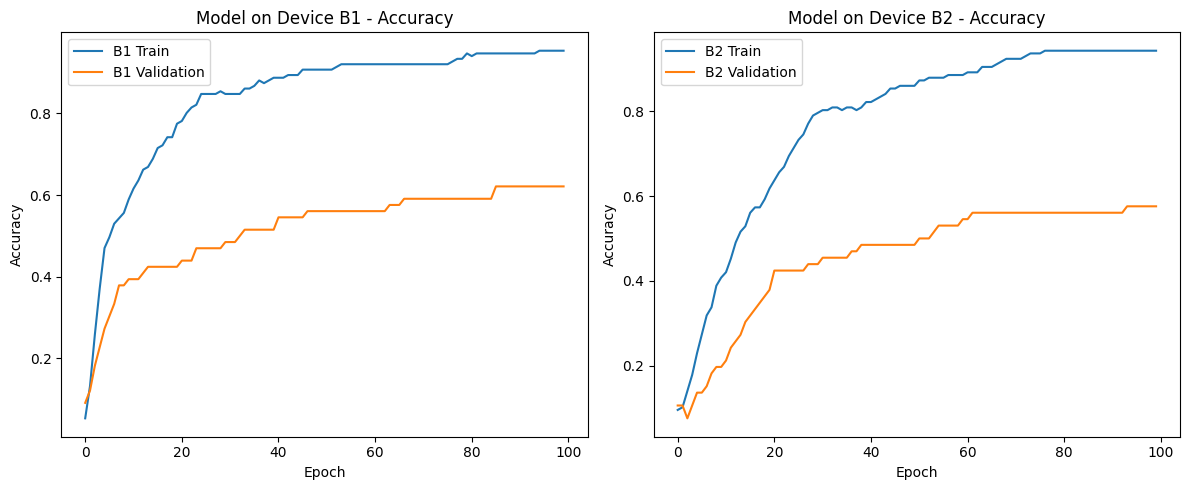

In [19]:
# Plot training loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_on_device_B1.history['loss'], label='B1 Train')
plt.plot(history_on_device_B1.history['val_loss'], label='B1 Validation')
plt.title('Model on Device B1 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_on_device_B2.history['loss'], label='B2 Train')
plt.plot(history_on_device_B2.history['val_loss'], label='B2 Validation')
plt.title('Model on Device B2 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot training accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_on_device_B1.history['accuracy'], label='B1 Train')
plt.plot(history_on_device_B1.history['val_accuracy'], label='B1 Validation')
plt.title('Model on Device B1 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_on_device_B2.history['accuracy'], label='B2 Train')
plt.plot(history_on_device_B2.history['val_accuracy'], label='B2 Validation')
plt.title('Model on Device B2 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Create a shared model B3

In [20]:
# Get the weights of B1 and B2
weights_B1 = model_on_device_B1.get_weights()
weights_B2 = model_on_device_B2.get_weights()

# Average the weights
average_weights = [(w1 + w2) / 2 for w1, w2 in zip(weights_B1, weights_B2)]

# Create a new model with the same architecture as B1
input_shape_B1 = B1_processed.shape[1]
model_on_device_B3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, activation='relu', input_shape=(input_shape_B1,)),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Set the weights of B3 to the averaged weights
model_on_device_B3.set_weights(average_weights)

# Print summary of the new model
model_on_device_B3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 20)                1300      
                                                                 
 dense_8 (Dense)             (None, 10)                210       
                                                                 
Total params: 1510 (5.90 KB)
Trainable params: 1510 (5.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Evaluate on-laptop models
We now evaluate the small models trained on laptop, mimicking the processes on the arduinos

2/2 [==============================] - 0s 5ms/step
Evaluation for model_B1:
Accuracy: 0.16666666666666666
Precision: 0.5008169934640523
Recall: 0.16666666666666666
F1-score: 0.10079365079365081

Evaluation for model_B2:
Accuracy: 0.1111111111111111
Precision: 0.38232323232323234
Recall: 0.1111111111111111
F1-score: 0.07000407000407

Evaluation for model_B3:
Accuracy: 0.1111111111111111
Precision: 0.4823232323232323
Recall: 0.1111111111111111
F1-score: 0.10042735042735043



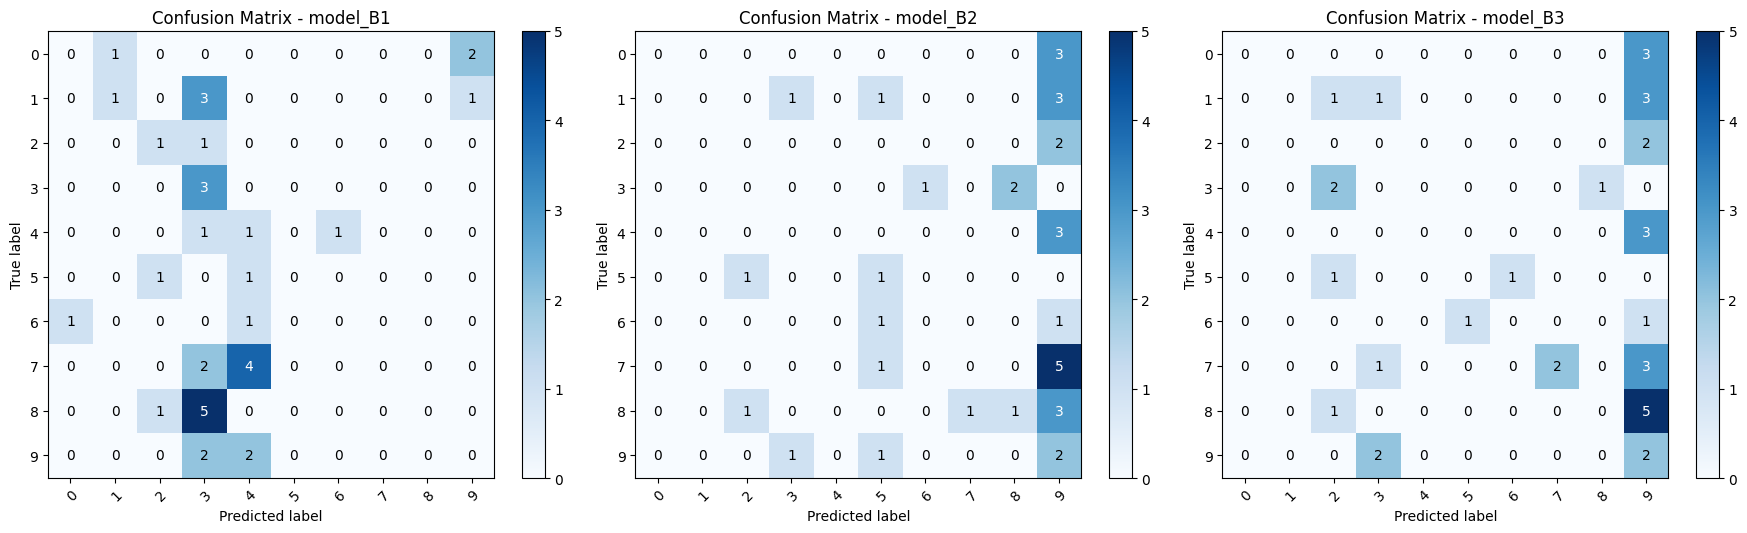

3/3 [==============================] - 0s 3ms/step
Evaluation for model_B1:
Accuracy: 0.6417910447761194
Precision: 0.7651115054100129
Recall: 0.6417910447761194
F1-score: 0.5226944985218833

Evaluation for model_B2:
Accuracy: 0.6119402985074627
Precision: 0.793078563227817
Recall: 0.6119402985074627
F1-score: 0.5207717132304721

Evaluation for model_B3:
Accuracy: 0.3880597014925373
Precision: 0.5020319525367813
Recall: 0.3880597014925373
F1-score: 0.3005427408412484



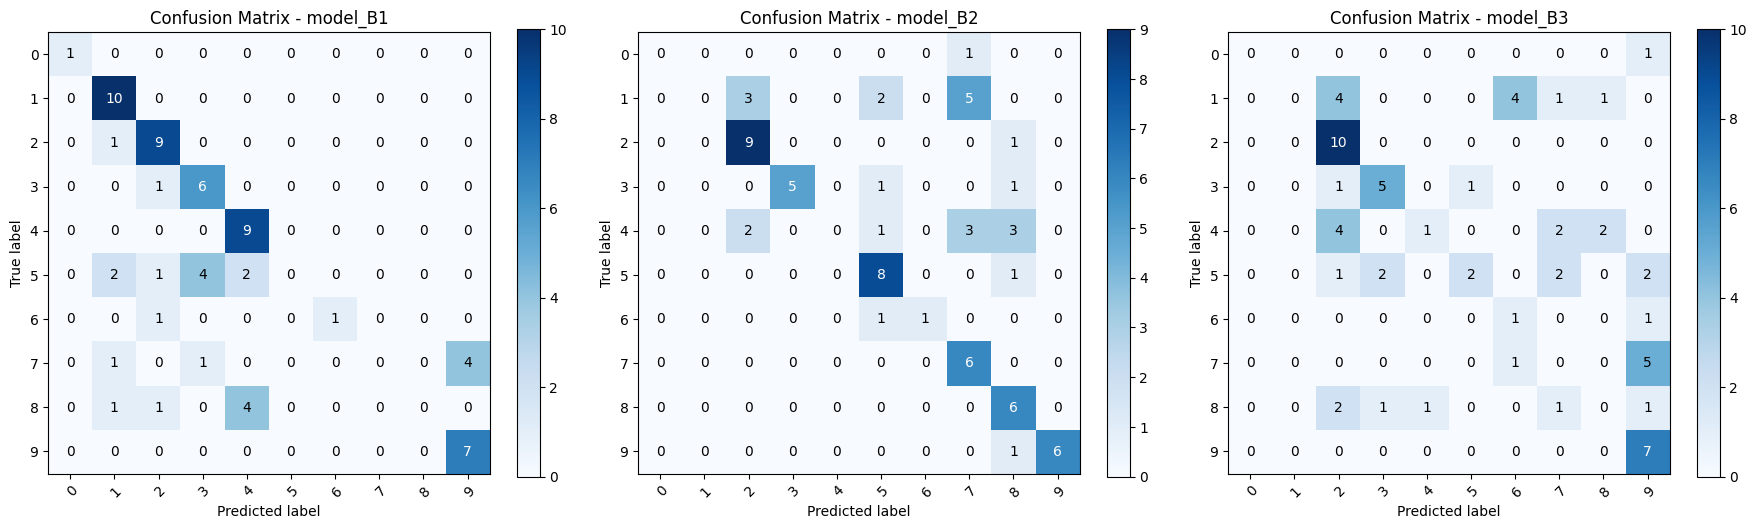

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import tensorflow as tf

def evaluate_models(data_processed, labels, model_B1, model_B2, model_B3):
    # Predict on the dataset
    predictions_B1 = model_B1.predict(data_processed)
    predictions_B2 = model_B2.predict(data_processed)
    predictions_B3 = model_B3.predict(data_processed)

    # Convert predictions to class labels
    predicted_labels_B1 = np.argmax(predictions_B1, axis=1)
    predicted_labels_B2 = np.argmax(predictions_B2, axis=1)
    predicted_labels_B3 = np.argmax(predictions_B3, axis=1)

    # Convert labels to class labels
    true_labels = np.argmax(labels, axis=1)

    # Evaluate models
    evaluation_B1 = evaluate_model(true_labels, predicted_labels_B1)
    evaluation_B2 = evaluate_model(true_labels, predicted_labels_B2)
    evaluation_B3 = evaluate_model(true_labels, predicted_labels_B3)

    # Print evaluation metrics
    print_evaluation("model_B1", evaluation_B1)
    print_evaluation("model_B2", evaluation_B2)
    print_evaluation("model_B3", evaluation_B3)

    # Plot confusion matrices
    plot_confusion_matrices(true_labels, predicted_labels_B1, predicted_labels_B2, predicted_labels_B3)

def evaluate_model(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1.0)
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

def print_evaluation(model_name, evaluation):
    print(f"Evaluation for {model_name}:")
    print("Accuracy:", evaluation['accuracy'])
    print("Precision:", evaluation['precision'])
    print("Recall:", evaluation['recall'])
    print("F1-score:", evaluation['f1_score'])
    print()

def plot_confusion_matrices(true_labels, predicted_labels_B1, predicted_labels_B2, predicted_labels_B3):
    # Function to plot confusion matrix
    def plot_confusion_matrix(ax, y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
        cm = confusion_matrix(y_true, y_pred)
        classes = [str(c) for c in classes]

        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)

        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")

    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Plot confusion matrix for model_B1
    plot_confusion_matrix(axs[0], true_labels, predicted_labels_B1, classes=np.unique(true_labels), title='Confusion Matrix - model_B1')

    # Plot confusion matrix for model_B2
    plot_confusion_matrix(axs[1], true_labels, predicted_labels_B2, classes=np.unique(true_labels), title='Confusion Matrix - model_B2')

    # Plot confusion matrix for model_B3
    plot_confusion_matrix(axs[2], true_labels, predicted_labels_B3, classes=np.unique(true_labels), title='Confusion Matrix - model_B3')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Assuming arduino_data_processed and arduino_labels are available
# Also assuming model_on_device_B1, model_on_device_B2, model_on_device_B3 are defined
evaluate_models(arduino_data_processed, arduino_labels, model_on_device_B1, model_on_device_B2, model_on_device_B3)
evaluate_models(x_test_b_processed, y_test_b, model_on_device_B1, model_on_device_B2, model_on_device_B3)

# Export data for on-device training
Having processed the training, validation and generalization data, it now needs to be formated for export.
The C++ template code we're using for the Arduino expexts comma-seperated data wrapped in curly braces. Futher, labels should not be one-hot encoded.

Data and labels are exported to individual files to facilitate easy manual transfer to the arduino.

## Alternative 1: Export of individual objects

In [22]:
def process_and_export_samples(data, file_path):
    # Convert the numpy array to a list of lists
    data_list = data.tolist()

    # Convert each inner list to a formatted string with curly braces
    data_rows = ["{" + ", ".join(map(str, row)) + "}" for row in data_list]

    # Join the formatted rows and enclose them in curly braces
    formatted_output = "{" + "\n  " + ",\n  ".join(data_rows) + "\n}"

    with open(file_path, 'w') as file:
        file.write(formatted_output)
    print("Data has been exported to the file", file_path)
    
def process_and_export_labels(labels, file_path):
    # Convert one-hot encoded labels back to integer labels, for transfer to C++
    integers = np.argmax(labels, axis=1)
    
    # Format each integer label as a string with curly braces
    formatted_labels =  "{" + ", ".join(map(str, integers)) + "}"
    
    # Write the formatted labels to the file
    with open(file_path, 'w') as file:
        file.write(formatted_labels)
    print("Labels has been exported to the file", file_path)

In [23]:
# Print Data
process_and_export_samples(B1_processed, '/kaggle/working/B1_data_processed.h')
process_and_export_samples(B2_processed, '/kaggle/working/B2_data_processed.h')
process_and_export_samples(x_val_b_processed, '/kaggle/working/val_data_processed.h')
process_and_export_samples(x_test_b_processed, '/kaggle/working/test_data_processed.h')
process_and_export_samples(arduino_data_processed, '/kaggle/working/arduino_images_processed.h')

#Print labels
process_and_export_labels(B1_labels, '/kaggle/working/B1_labels.h')
process_and_export_labels(B2_labels, '/kaggle/working/B2_labels.h')
process_and_export_labels(y_val_b, '/kaggle/working/validation_labels.h')
process_and_export_labels(y_test_b, '/kaggle/working/test_labels.h')
process_and_export_labels(arduino_labels, '/kaggle/working/arduino_labels.h')

Data has been exported to the file /kaggle/working/B1_data_processed.h
Data has been exported to the file /kaggle/working/B2_data_processed.h
Data has been exported to the file /kaggle/working/val_data_processed.h
Data has been exported to the file /kaggle/working/test_data_processed.h
Data has been exported to the file /kaggle/working/arduino_images_processed.h
Labels has been exported to the file /kaggle/working/B1_labels.h
Labels has been exported to the file /kaggle/working/B2_labels.h
Labels has been exported to the file /kaggle/working/validation_labels.h
Labels has been exported to the file /kaggle/working/test_labels.h
Labels has been exported to the file /kaggle/working/arduino_labels.h


## Alternative 2: Autogenerate the entire C++ header file
The code below autogenerates the entire C++ header file.

Note that one must manually remove some extra curly braces {} which appears in the output file. They were notoriously difficult to get rid of!

In [25]:
def process_samples(data):
    # Convert the numpy array to a list of lists
    data_list = data.tolist()

    # Convert each inner list to a formatted string with curly braces
    data_rows = [
        "{" + ", ".join(map(lambda x: f"{x:.9f}", row)) + "}" for row in data_list
    ]

    # Join the formatted rows and enclose them in curly braces
    formatted_output = "{" + ",\n    ".join(data_rows) + "}"

    return formatted_output

def process_labels(labels):
    # Convert one-hot encoded labels back to integer labels, for transfer to C++
    integers = np.argmax(labels, axis=1)
    
    # Format each integer label as a string with curly braces
    formatted_labels =  "{" + ", ".join(map(str, integers)) + "}"
    
    return formatted_labels

def generate_cpp_header(B1_processed, x_val_b_processed, x_test_b_processed, B1_labels, y_val_b, y_test_b, path):
    
    # Dynamically calculate variable values
    num_features = B1_processed.shape[1]
    train_data_cnt = len(B1_processed)
    validation_data_cnt = len(x_val_b_processed)
    test_data_cnt = len(x_test_b_processed)
    classes_cnt = B1_labels.shape[1]

    # Process data and labels for export
    B1_data_formatted = process_samples(B1_processed)
    x_val_data_formatted = process_samples(x_val_b_processed)
    x_test_data_formatted = process_samples(x_test_b_processed)
    B1_labels_formatted = process_labels(B1_labels)
    y_val_labels_formatted = process_labels(y_val_b)
    y_test_labels_formatted = process_labels(y_test_b)

    # Create the C++ header content with newlines
    cpp_header_content = f'''
const int first_layer_input_cnt = {num_features};
const int train_data_cnt = {train_data_cnt};
const int validation_data_cnt = {validation_data_cnt};
const int test_data_cnt = {test_data_cnt};
const int classes_cnt = {classes_cnt};

const char* classes[classes_cnt] = {{
  "Speed limit (50km/h)", "No passing", "Stop", "Veh > 3.5 tons prohibited", "No entry", "Turn right ahead", "Turn left ahead", "Keep right", "Keep left", "Roundabout mandatory"
}};

const int train_labels[train_data_cnt] = {{
    {B1_labels_formatted}
}};

const int validation_labels[validation_data_cnt] = {{
    {y_val_labels_formatted}
}};

const int test_labels[test_data_cnt] = {{
    {y_test_labels_formatted}
}};

const float cnn_train_data[train_data_cnt][first_layer_input_cnt] = {{
    {B1_data_formatted}
}};

const float cnn_validation_data[validation_data_cnt][first_layer_input_cnt] = {{
    {x_val_data_formatted}
}};

const float cnn_test_data[test_data_cnt][first_layer_input_cnt] = {{
    {x_test_data_formatted}
}};
'''

    # Save to file
    with open(path, 'w') as file:
        file.write(cpp_header_content)

# Function Call
generate_cpp_header(B1_processed, x_val_b_processed, x_test_b_processed, B1_labels, y_val_b, y_test_b, '/kaggle/working/data_b1.h')
generate_cpp_header(B2_processed, x_val_b_processed, x_test_b_processed, B2_labels, y_val_b, y_test_b, '/kaggle/working/data_b2.h')
generate_cpp_header(B1_processed, x_val_b_processed, arduino_data_processed, B1_labels, y_val_b, arduino_labels, '/kaggle/working/data_b1_arduino.h')
generate_cpp_header(B2_processed, x_val_b_processed, arduino_data_processed, B2_labels, y_val_b, arduino_labels, '/kaggle/working/data_b2_arduino.h')

# Plot export for report

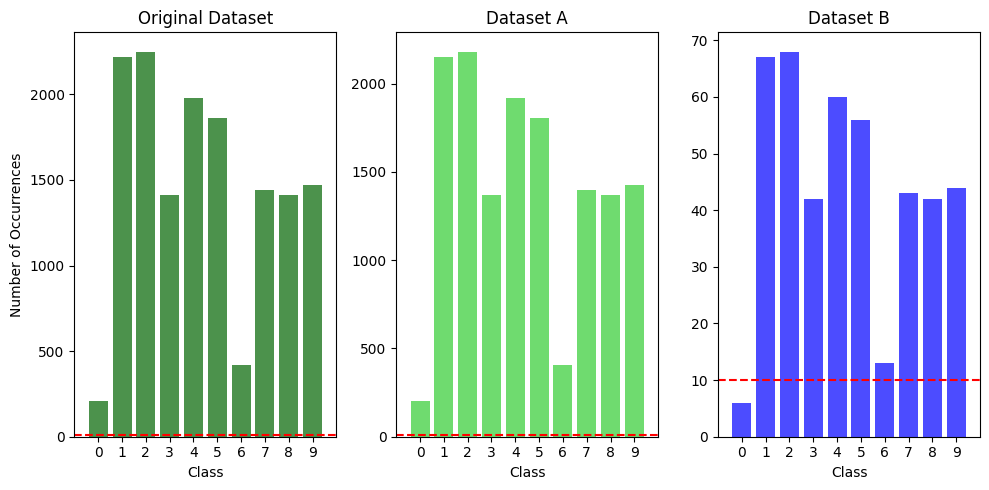

In [45]:
# Get unique classes and their counts for image_data_a,after convert back from one-hot
integer_labels_original = np.argmax(image_labels, axis=1)
integer_labels_a = np.argmax(image_labels_a, axis=1)
integer_labels_b = np.argmax(image_labels_b, axis=1)
classes_original, counts_original = np.unique(integer_labels_original, return_counts=True)
classes_a, counts_a = np.unique(integer_labels_a, return_counts=True)
classes_b, counts_b = np.unique(integer_labels_b, return_counts=True)

plt.figure(figsize=(10, 5))

# Plot histogram for the original dataset
plt.subplot(1, 3, 1)
plt.bar(classes_original, counts_original, color='darkgreen', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.title('Original Dataset')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

# Plot histogram for image_data_a
plt.subplot(1, 3, 2)
plt.bar(classes_a, counts_a, color='limegreen', alpha=0.7)
plt.xlabel('Class')
plt.title('Dataset A')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

# Plot histogram for image_data_b
plt.subplot(1, 3, 3)
plt.bar(classes_b, counts_b, color='blue', alpha=0.7)
plt.xlabel('Class')
plt.title('Dataset B')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

plt.savefig('/kaggle/working/plotOAB.png')
plt.tight_layout()
plt.show()


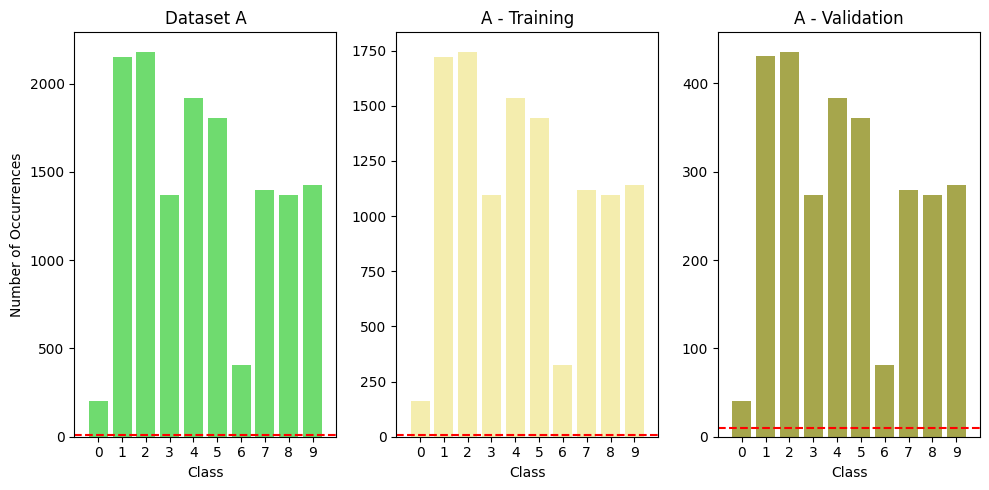

In [46]:
integer_labels_train_a = np.argmax(y_train_a, axis=1)
classes_train_a, counts_train_a = np.unique(integer_labels_train_a, return_counts=True)
integer_labels_val_a = np.argmax(y_val_a, axis=1)
classes_val_a, counts_val_a = np.unique(integer_labels_val_a, return_counts=True)

plt.figure(figsize=(10, 5))

# Plot histogram for image_data_a
plt.subplot(1, 3, 1)
plt.bar(classes_a, counts_a, color='limegreen', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.title('Dataset A')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

# Plot histogram for the training set of Model A
plt.subplot(1, 3, 2)
plt.bar(classes_train_a, counts_train_a, color='khaki', alpha=0.7)
plt.xlabel('Class')
plt.title('A - Training')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

# Plot histogram for the validation set of Model A
plt.subplot(1, 3, 3)
plt.bar(classes_val_a, counts_val_a, color='olive', alpha=0.7)
plt.xlabel('Class')
plt.title('A - Validation')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

plt.savefig('/kaggle/working/plotA.png')
plt.tight_layout()
plt.show()

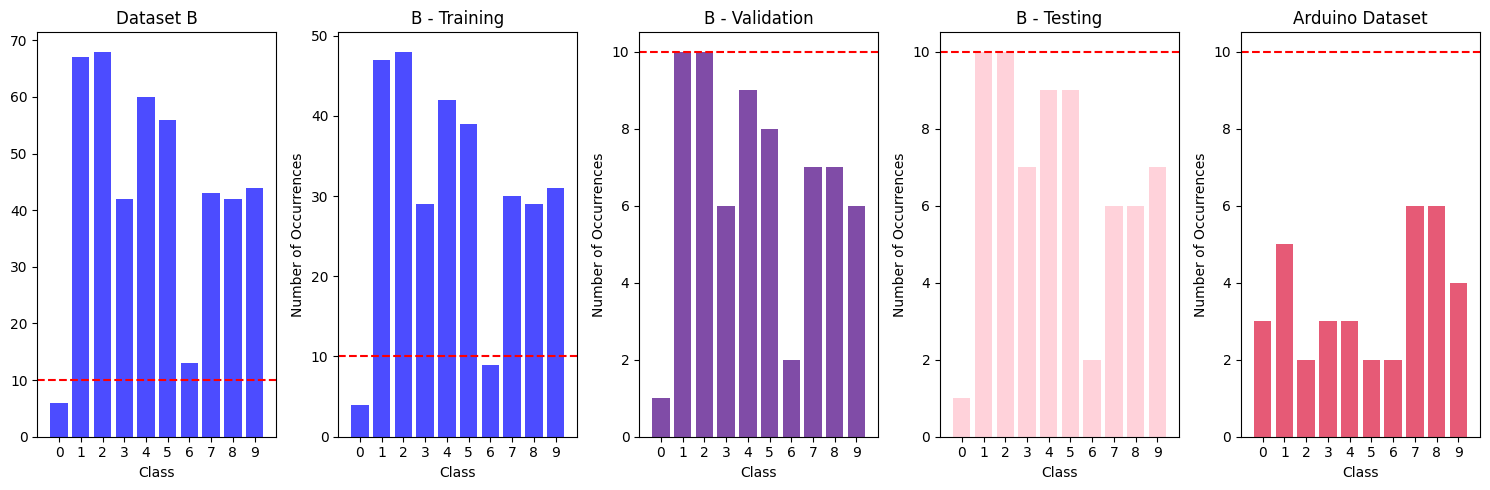

In [47]:
# Plot histogram for dataset validation
plt.figure(figsize=(15, 5))

# Plot histogram for image_data_b
plt.subplot(1, 5, 1)
plt.bar(classes_b, counts_b, color='blue', alpha=0.7)
plt.xlabel('Class')
plt.title('Dataset B')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

# Plot histogram for dataset B
plt.subplot(1, 5, 2)
plt.bar(classes_B, counts_B, color='blue', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.title('B - Training')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

plt.subplot(1, 5, 3)
plt.bar(classes_val, counts_val, color='indigo', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.title('B - Validation')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

# Plot histogram for dataset validation
plt.subplot(1, 5, 4)
plt.bar(classes_test, counts_test, color='pink', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.title('B - Testing')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

# Plot histogram for dataset validation
plt.subplot(1, 5, 5)
plt.bar(classes_arduino, counts_arduino, color='crimson', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.title('Arduino Dataset')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

plt.savefig('/kaggle/working/plotB.png')
plt.tight_layout()
plt.show()

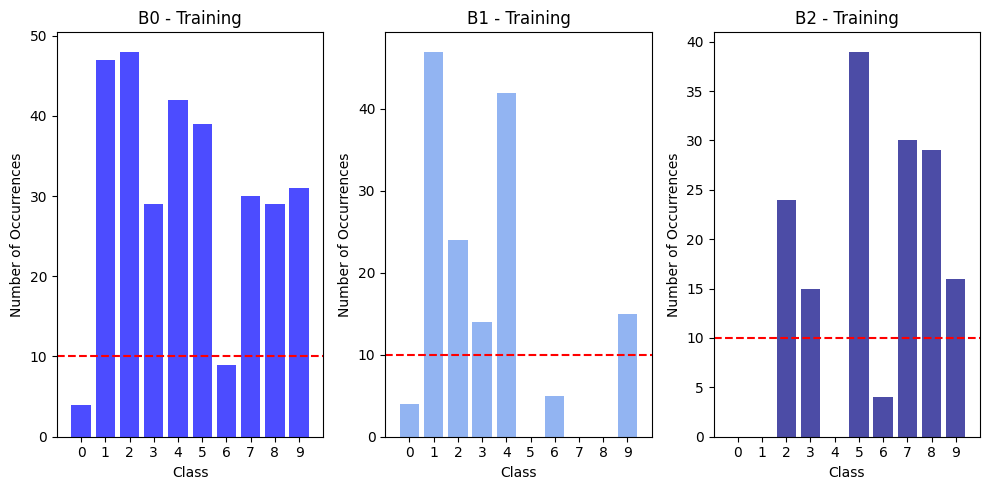

In [48]:
# Get unique classes and their counts, after convert back from one-hot
integer_labels_B = np.argmax(y_train_b, axis=1)
integer_labels_B1 = np.argmax(B1_labels, axis=1)
integer_labels_B2 = np.argmax(B2_labels, axis=1)
integer_labels_val_b = np.argmax(y_val_b, axis=1)
integer_labels_test_b = np.argmax(y_test_b, axis=1)
integer_labels_arduino = np.argmax(arduino_labels, axis=1)

# Get frequency of each class
classes_B, counts_B = np.unique(integer_labels_B, return_counts=True)
classes_B1, counts_B1 = np.unique(integer_labels_B1, return_counts=True)
classes_B2, counts_B2 = np.unique(integer_labels_B2, return_counts=True)
classes_val, counts_val = np.unique(integer_labels_val_b, return_counts=True)
classes_test, counts_test = np.unique(integer_labels_test_b, return_counts=True)
classes_arduino, counts_arduino = np.unique(integer_labels_arduino, return_counts=True)

plt.figure(figsize=(10, 5))

# Plot histogram for dataset B
plt.subplot(1, 3, 1)
plt.bar(classes_B, counts_B, color='blue', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.title('B0 - Training')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

# Plot histogram for dataset B1
plt.subplot(1, 3, 2)
plt.bar(classes_B1, counts_B1, color='cornflowerblue', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.title('B1 - Training')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

# Plot histogram for dataset B2
plt.subplot(1, 3, 3)
plt.bar(classes_B2, counts_B2, color='navy', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.title('B2 - Training')
plt.xlim(-1, 10)
plt.xticks(range(10))
plt.axhline(y=10, color='red', linestyle='--')

plt.savefig('/kaggle/working/plotB0B1B2.png')
plt.tight_layout()
plt.show()